# Scratchpad to study the factorization problem

Data Generation

In [1]:
from pathlib import Path
import numpy as np
import torch

save_dir = Path('.').resolve() / 'results'

vocab_size = 2
bsz = 2048
length = 3
sparsity_index = 5

# we create a modular addition problem on some subset of the input only
data = np.random.rand(bsz, length) // (1 / vocab_size)
targets = data[:, :sparsity_index].sum(axis=1) % vocab_size

test_bsz = 128
test_data = np.random.rand(test_bsz, length) // (1 / vocab_size)
test_targets = test_data[:, :sparsity_index].sum(axis=1) % vocab_size

In [2]:
print(f"Total number of unique sequences {vocab_size ** length}")

Total number of unique sequences 4096


Model

In [3]:
import math
import torch.nn as nn
import torch.nn.functional as F

class SoftmaxLayer(nn.Module):
    def __init__(self, emb_dim):
        super(SoftmaxLayer, self).__init__()
        self.emb_dim = emb_dim
        self.query = nn.Linear(emb_dim, 1, bias=False)
        self.value = nn.Linear(emb_dim, emb_dim, bias=False)

    def forward(self, x, verbose=False):
        # x: [bsz, seq_len, emb_dim]
        query = self.query.weight
        key = x
        value = self.value(x)

        attn = query @ key.transpose(-1, -2) / math.sqrt(self.emb_dim)
        attn = F.softmax(attn, dim=-1)
        out = (attn @ value).squeeze(1)
        if verbose:
            return out, attn.squeeze(1)
        return out


In [4]:
from dataclasses import dataclass
from models.mlp import TransformerFeedForward
from models.normalization import RMSNorm

@dataclass
class MLPConfig:
    activation: float = "gelu"
    emb_dim: bool = None
    ffn_dim: bool = None
    ffn_bias: bool = False
    ffn_dropout: float = 0

    def __post_init__(self):
        if self.ffn_dim is None:
            self.ffn_dim = 4 * self.emb_dim


class Model(nn.Module):
    def __init__(self, emb_dim, vocab_size):
        super(Model, self).__init__()
        self.token_emb = nn.Embedding(vocab_size, emb_dim)
        self.pos_emb = nn.Embedding(length, emb_dim)

        self.softmax = SoftmaxLayer(emb_dim)
        config = MLPConfig(
            emb_dim=emb_dim,
            ffn_dim=4 * emb_dim,
            ffn_bias=True,
            activation="gelu",
        )
        self.mlp = TransformerFeedForward(config)

        self.output = nn.Linear(emb_dim, vocab_size, bias=False)
        self.output.weight = self.token_emb.weight

        self.norm1 = RMSNorm()
        self.norm2 = RMSNorm()

    def forward(self, x, verbose=False):
        out = self.token_emb(x) + self.pos_emb.weight
        out = self.softmax(self.norm1(out), verbose=verbose)
        if verbose:
            out, attn = out
        out = out + self.mlp(self.norm2(out))
        out = self.output(out)
        if verbose:
            return out, attn
        return out

In [5]:
emb_dim = 32

X = torch.from_numpy(data.astype(int))
model = Model(emb_dim, vocab_size)

Training

TODO - cut the data into batches for each epochs

In [6]:
DEVICE = torch.device('cuda:0')

niter = 10_000

all_losses = {}
all_accs = {}
all_test_accs = {}
all_attns = {}
# names = ['SGD', 'Adam', 'AdamLN', 'SGDLN']
names = ['Adam']

X = torch.from_numpy(data).to(dtype=torch.long, device=DEVICE)
Y = torch.from_numpy(targets).to(dtype=torch.long, device=DEVICE)

X_test = torch.from_numpy(test_data).to(dtype=torch.long, device=DEVICE)
Y_test = torch.from_numpy(test_targets).to(dtype=torch.long, device=DEVICE)

for name in names:
    print(name, flush=True)

    model = Model(emb_dim, vocab_size)
    model.to(device=DEVICE)
    if name[:3] == 'SGD':
        lr = 1e-1
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
    else:
        lr = 1e-4
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = torch.zeros(niter)
    accs = torch.zeros(niter)
    test_accs = torch.zeros(niter)
    attns = torch.zeros((niter, test_bsz, length))

    for i in range(niter):
        optimizer.zero_grad()

        # compute loss
        score = model(X, verbose=False)
        loss = F.cross_entropy(score.view((-1, vocab_size)), Y.view(-1))

        loss.backward()
        optimizer.step()

        # record statistics
        with torch.no_grad():
            losses[i] = loss.item()
            accs[i] = (score.argmax(-1) == Y).float().mean()
            score_test, attn = model(X_test, verbose=True)
            test_accs[i] = (score_test.argmax(-1) == Y_test).float().mean()
            attns[i] = attn
    
    all_losses[name] = losses
    all_accs[name] = accs
    all_test_accs[name] = test_accs
    all_attns[name] = attns

    # save model
    torch.save(model.state_dict(), save_dir / f'{name}.pt')

Adam


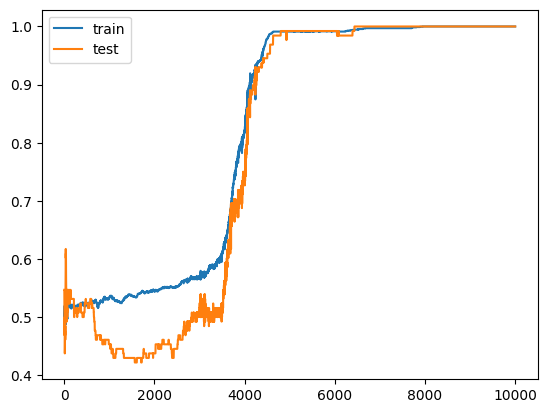

In [7]:
import matplotlib.pyplot as plt
plt.plot(all_accs['Adam'], label='train')
plt.plot(all_test_accs['Adam'], label='test')
plt.legend()

Visualize attention evolution

In [2]:
from pathlib import Path
import numpy as np

from visualization.graph import build_1L_graph
save_dir = Path('.').resolve() / 'results'
attns = np.load(save_dir / 'attns.npy')

In [31]:
print(weight)

[0.09562261 0.09778544 0.18479452 0.11105744 0.06448481 0.0943031
 0.12039803 0.08254003 0.03099724 0.03888853 0.04592875 0.03319949]


/home/vivc/.local/share/texlive/2022/bin/x86_64-linux/pdflatex


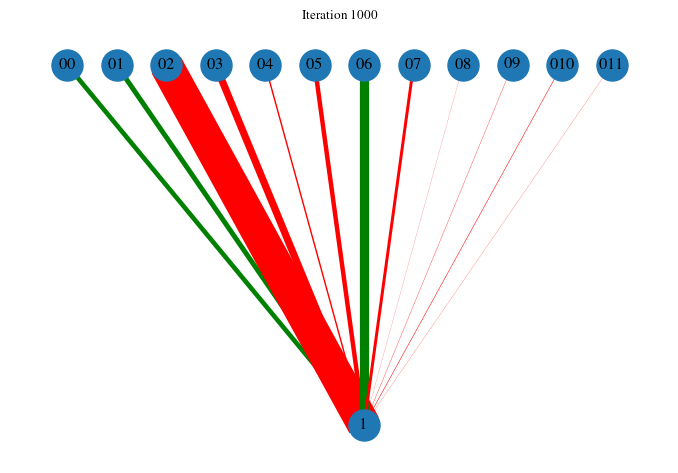

In [37]:
import subprocess
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from matplotlib import rc

plt.rc("font", family="serif", size=8)

WIDTH = 8.5  # inches (from ICML style file)
HEIGHT = 8.5 / 1.5  # golden ratio

rc("font", family="serif", size=8)
usetex = not subprocess.run(["which", "pdflatex"]).returncode
rc("text", usetex=usetex)
if usetex:
    rc("text.latex", preamble=r"\usepackage{times}")

N = 12

fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))
G, pos = build_1L_graph(N)
magnifier = 50
weights = 0

def update(frame):
    global weights

    # update variables
    ax.clear()
    old_weights = weights
    weights = attns[10 * frame].mean(axis=0)
    T = 0.01
    weights = np.exp(weights / T)
    weights /= np.sum(weights)

    # color edges according to updates
    diff = weights - old_weights
    colors = ["green" if d > 0 else "red" for d in diff]

    # draw the updated graph
    nx.draw(
        G,
        pos,
        width=magnifier * weights,
        with_labels=True,
        edge_color=colors,
        node_size=500,
        ax=ax,
    )
    ax.set_title(f"Iteration {frame+1}", fontweight="bold")


ani_length = 1_000
ani = animation.FuncAnimation(fig, update, frames=ani_length, repeat=False)
# ani.save("test.gif", writer="imagemagick", fps=5)
ani.save("test.mp4", writer="ffmpeg", fps=10)

In [8]:
import pickle
with open(save_dir / 'losses.pkl', 'wb') as f:
    pickle.dump(all_losses, f)
with open(save_dir / 'accs.pkl', 'wb') as f:
    pickle.dump(all_accs, f)